# São Tomé

We will begin by loading all the required libraries and packages:

In [1]:
from sys import argv
import numpy as np
import pandas as pd
from os import path
from sys import argv
from copy import deepcopy
import matplotlib.pyplot as plt
from numpy.random import uniform
from sklearn.preprocessing import normalize
import MGSurvE as srv
import cartopy.crs as ccrs

## Landscape

We will now setup some of the experiment's constants:

In [11]:
(TRPS_NUM, FXD_TRPS) = (5, True)
# Experiment ID (RID) and stochastic iteration id (RID) -----------------------
(ID, RID) = ('STP', 0)
IX_SPLIT = 27
# Output folder ---------------------------------------------------------------
OUT_PTH = './sims_out/'
srv.makeFolder(OUT_PTH)

In [4]:
sites = pd.read_csv(path.join('./GEO', 'STP_LatLonN.csv'))
sites['t'] = [0]*sites.shape[0]
SAO_TOME_LL = sites.iloc[IX_SPLIT:]
SAO_bbox = (
    (min(SAO_TOME_LL['lon']), max(SAO_TOME_LL['lon'])),
    (min(SAO_TOME_LL['lat']), max(SAO_TOME_LL['lat']))
)
SAO_cntr = [i[0]+(i[1]-i[0])/2 for i in SAO_bbox]
SAO_LIMITS = ((6.41, 6.79), (-0.0475, .45))

In [5]:
SAO_FIXED = [51-IX_SPLIT, 239-IX_SPLIT]
FXD_NUM = len(SAO_FIXED)

In [6]:
migration = np.genfromtxt(
    path.join('./GEO', 'STP_MigrationN.csv'), delimiter=','
)
msplit = migration[IX_SPLIT:,IX_SPLIT:]
SAO_TOME_MIG = normalize(msplit, axis=1, norm='l1')

In [12]:
(initTyp, initFxd) = ([0]*TRPS_NUM, [0]*TRPS_NUM)
(initLon, initLat) = ([
    uniform(*SAO_bbox[0], TRPS_NUM), uniform(*SAO_bbox[1], TRPS_NUM)
])
if FXD_TRPS:
    initFxd = ([0]*(TRPS_NUM-FXD_NUM) + [1]*FXD_NUM)
sid = [0]*(TRPS_NUM-FXD_NUM) + SAO_FIXED 
traps = pd.DataFrame({
    'sid': sid,
    'lon': initLon, 'lat': initLat, 
    't': initTyp, 'f': initFxd
})
tKer = {0: {'kernel': srv.exponentialDecay, 'params': {'A': 0.5, 'b': 0.041674}}}

In [13]:
lnd = srv.Landscape(
    SAO_TOME_LL, migrationMatrix=SAO_TOME_MIG,
    traps=traps, trapsKernels=tKer, landLimits=SAO_LIMITS,
    trapsRadii=[1],
)
bbox = lnd.getBoundingBox()
trpMsk = srv.genFixedTrapsMask(lnd.trapsFixed)

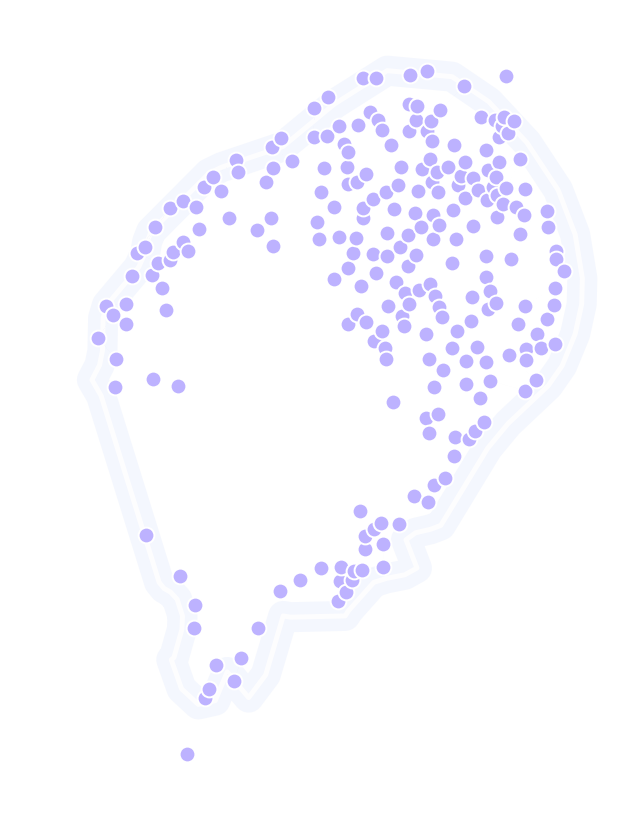

In [ ]:
(fig, ax) = (
    plt.figure(figsize=(15, 15)),
    plt.axes(projection=ccrs.PlateCarree())
)
lnd.plotSites(fig, ax, size=250)
lnd.plotMigrationNetwork(
    fig, ax, lineWidth=60, alphaMin=.1, alphaAmplitude=5,
)
lnd.plotLandBoundary(fig, ax)
srv.plotClean(fig, ax, bbox=lnd.landLimits)
fig.savefig(
    path.join(OUT_PTH, '{}_{:02d}_CLN.png'.format(ID, TRPS_NUM)), 
    facecolor='w', bbox_inches='tight', pad_inches=0.1, dpi=300
)
# Plot Traps Kernels ----------------------------------------------------------
(fig, ax) = plt.subplots(1, 1, figsize=(15, 5), sharey=False)
(fig, ax) = srv.plotTrapsKernels(fig, ax, lnd, distRange=(0, 100), aspect=.175)
fig.savefig(
    path.join(OUT_PTH, '{}D-{}_{:02d}-{:02d}_KER.png'.format(ID, AP, TRPS_NUM, RID)), 
    facecolor='w', bbox_inches='tight', pad_inches=0.1, dpi=300
)

## Optimization

In [20]:
(GENS, GA_SUMSTAT, VERBOSE) = (2500, np.mean, False)
POP_SIZE = int(10*(lnd.trapsNumber*1.5))
(MAT, MUT, SEL) = (
    {'cxpb':  0.300, 'indpb': 0.35}, 
    {'mutpb': 0.375, 'indpb': 0.50},
    {'tSize': 3}
)
VERBOSE = True
lndGA = deepcopy(lnd)
# Reducing the bbox for init sampling -----------------------------------------
redFract = .25
reduction = [(i[1]-i[0])/2*redFract for i in bbox]
bboxRed = [(i[0]+r, i[1]-r) for (i, r) in zip(bbox,reduction)]

In [21]:
outer = GA_SUMSTAT
(lnd, logbook) = srv.optimizeDiscreteTrapsGA(
    lndGA, pop_size=POP_SIZE, generations=GENS, verbose=VERBOSE,
    mating_params=MAT, mutation_params=MUT, selection_params=SEL,
    fitFuns={'inner': np.sum, 'outer': outer}
)
srv.exportLog(logbook, OUT_PTH, '{}D-{}_{:02d}-{:02d}_LOG'.format(ID, AP, TRPS_NUM, RID))
srv.dumpLandscape(lnd, OUT_PTH, '{}D-{}_{:02d}-{:02d}_TRP'.format(ID, AP, TRPS_NUM, RID), fExt='pkl')

## Analysis

In [ ]:
lnd = srv.loadLandscape(
    OUT_PTH, '{}D-{}_{:02d}-{:02d}_TRP'.format(ID, AP, TRPS_NUM, RID), 
    fExt='pkl'
)
(fig, ax) = (
    plt.figure(figsize=(15, 15)),
    plt.axes(projection=ccrs.PlateCarree())
)
lnd.plotSites(fig, ax, size=250)
# lnd.plotMigrationNetwork(
#     fig, ax, lineWidth=30, alphaMin=.25, alphaAmplitude=2.5
# )
lnd.updateTrapsRadii([0.250, 0.125, 0.100])
lnd.plotTraps(
    fig, ax, 
    zorders=(30, 25), transparencyHex='55', 
    latlon=True, proj=ccrs.PlateCarree()
)
srv.plotClean(fig, ax, bbox=lnd.landLimits)
# srv.plotFitness(fig, ax, min(dta['min']), fmt='{:.2f}')
lnd.plotLandBoundary(fig, ax)
# srv.plotClean(fig, ax, bbox=lnd.landLimits)
fig.savefig(
    path.join(OUT_PTH, '{}D-{}_{:02d}-{:02d}_TRP.png'.format(ID, AP, TRPS_NUM, RID)), 
    facecolor='w', bbox_inches='tight', pad_inches=0.1, dpi=400
)
# GA --------------------------------------------------------------------------
log = pd.DataFrame(logbook)
log.rename(columns={'median': 'avg'}, inplace=True)
(fig, ax) = plt.subplots(1, 1, figsize=(15, 5), sharey=False)
srv.plotGAEvolution(
    fig, ax, log,
    colors={'mean': '#ffffff', 'envelope': '#1565c0'},
    alphas={'mean': .75, 'envelope': 0.5},
    aspect=1/3
)
ax.set_ylim(0, 1500)
fig.savefig(
    path.join(OUT_PTH, '{}D-{}_{:02d}-{:02d}_GA.png'.format(ID, AP, TRPS_NUM, RID)),  
    facecolor='w', bbox_inches='tight', pad_inches=0.1, dpi=300
)